In [4]:
!pip install node2vec
!pip install networkx
!pip install sklearn

     |████████████████████████████████| 23.8 MB 12.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=c9d1000b5d00b5f155cca047315a062c91506caeda13baef186a08e7c8b707fa
  Stored in directory: /home/satyr/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [5]:
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()

Load the dataset:

In [8]:
df = pd.read_csv('../annotations/data/classification_dataset.csv')
#df = pd.read_csv('../wykop_scraper/data/latest/comments.csv')
#df = df.iloc[:, 1:]

In [9]:
df.head()

,Unnamed: 0,comment_id,entry_id,date,text,author_login,vote_count,receiver,hate_word_counts,is_hateful,annotation
0,0,185386257,52292479,2020-09-23 00:18:39,Ty no kurwa że też ja na to nie wpadłem ale ze...,Cybek-Marian,1,atteint,2,1,0
1,3,174804569,49417029,2020-05-14 19:45:44,coś ponad 1 a mniej niż 2,wytrzzeszcz,1,Kosciany,0,0,0
2,6,189533891,53440779,2020-11-09 20:41:58,Motor ma już w garażu,piSSowiec39,3,Zagmadfany2,0,0,0
3,9,172538589,48804329,2020-04-17 01:00:24,znow robic na tego zlodzieja,ranunculus,3,Graner,0,0,0
4,12,185485247,52313979,2020-09-24 11:51:11,kurwa człowieku no do kurwy nędzy chociaż wytn...,Cybek-Marian,0,AgentGRU,3,1,1


In [12]:
tags_df = pd.read_csv('../wykop_scraper/data/latest/tags.csv')
comments = pd.read_csv('../wykop_scraper/data/latest/comments.csv')

In [13]:
tags_df.tag.value_counts()

#koronawirus      4724
#heheszki         4376
#patostreamy      4077
#przegryw         3561
#polityka         3341
                  ... 
#souljazz            1
#blackandwhite       1
#bezpeczenstwo       1
#egzorcyzmy          1
#hyoyeon             1
Name: tag, Length: 17418, dtype: int64

In [14]:
tag_df_counts = tags_df.tag.value_counts().to_dict()

tags_df = tags_df[tags_df.tag.apply(tag_df_counts.get) > 1]
tags_df

,entry_id,comment_id,tag
0,53777179,NaN,#pytanie
1,53777179,NaN,#finanse
2,53777179,NaN,#pytaniedoeksperta
3,53777179,NaN,#gielda
4,53777129,NaN,#wykopaka
...,...,...,...
202158,45220929,NaN,#niebieskiepaski
202159,45220929,NaN,#rozowepaski
202161,45220629,NaN,#dziendobry
202162,45220629,NaN,#kawatime


In [15]:
most_used_tags = tags_df.merge(df, on='entry_id')[['author_login', 'tag']].groupby('author_login').agg(lambda x: x.value_counts().index[0]).reset_index()

In [16]:
most_used_tags

,author_login,tag
0,10129,#przegryw
1,A-10_Warthog,#anime
2,AGS__K,#polityka
3,Adu_Jean,#bigbrother
4,AgentGRU,#wybory
...,...,...
301,zartos,#przegryw
302,zastuj,#wiara
303,ziemba1,#konfederacja
304,zirytowana_plaszczka,#polityka


Create the list of edges:

In [17]:
df = df.dropna(subset=['author_login', 'receiver'])

In [18]:
edges = []
for index, row in df.iterrows():
    a = row['author_login']
    r = row['receiver']
    if not a or not r:
        continue
    if (a, r) not in edges:
        edges.append((a, r))

In [19]:
#edges = comments.loc[:, ['author_login', 'receiver']].dropna().values.tolist()
#edges

Create the graphs:

In [20]:
DG = nx.DiGraph()
DG.add_edges_from(edges)
UDG = DG.to_undirected()

Check if everything's ok:

In [21]:
print(nx.is_directed(DG))
print(nx.is_directed(UDG))

True
False


Check the graph size:

In [22]:
print(f'Number of nodes: {DG.number_of_nodes()}')
print(f'Number of edges: {DG.number_of_edges()}')
print(f'Number of connected components: {nx.number_connected_components(UDG)}') # not implemented for directed graphs

Number of nodes: 311
Number of edges: 3043
Number of connected components: 1


Create the Node2Vec:

In [23]:
node_size = 32
node2vec = Node2Vec(DG, dimensions=node_size, walk_length=16, num_walks=100, )

Computing transition probabilities:   0%|          | 0/311 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


In [24]:
model = node2vec.fit(window=10, min_count=1)

In [25]:
user_embeddings = {}
for node in UDG.nodes:
    if node not in user_embeddings.keys() and node in df.author_login.values:
        user_embeddings[node] = model.wv[node]

In [26]:
num_users = len(list(user_embeddings.keys()))
len(list(user_embeddings.keys()))

311

### Embeddings visualisation

In [27]:
X = np.zeros((num_users, node_size))
tags = []
for i, (user, emb) in enumerate(user_embeddings.items()):
    X[i, :] = emb
    tag = most_used_tags[most_used_tags.author_login == user].tag
    if not tag.empty:
        tags.append(tag.values[0])
    else:
        tags.append('OTHER')

In [28]:
tag_counts = pd.Series(tags).value_counts().to_dict()

tags = [tag if tag_counts[tag] > 6 else 'OTHER' for tag in tags]

In [29]:
tags

['#pdk',
 'OTHER',
 '#gownowpis',
 'OTHER',
 '#kononowicz',
 '#kononowicz',
 'OTHER',
 'OTHER',
 'OTHER',
 'OTHER',
 '#polityka',
 '#pdk',
 '#przegryw',
 'OTHER',
 '#kononowicz',
 'OTHER',
 'OTHER',
 'OTHER',
 'OTHER',
 '#przegryw',
 '#mikrokoksy',
 '#przegryw',
 '#mikrokoksy',
 '#mikrokoksy',
 'OTHER',
 '#polityka',
 'OTHER',
 'OTHER',
 'OTHER',
 '#przegryw',
 '#przegryw',
 'OTHER',
 'OTHER',
 '#pdk',
 'OTHER',
 '#przegryw',
 '#przegryw',
 '#przegryw',
 '#gownowpis',
 '#polityka',
 '#kononowicz',
 'OTHER',
 'OTHER',
 'OTHER',
 '#koronawirus',
 '#f1',
 '#kononowicz',
 'OTHER',
 '#przegryw',
 'OTHER',
 'OTHER',
 'OTHER',
 '#przegryw',
 '#przegryw',
 'OTHER',
 'OTHER',
 '#mikrokoksy',
 'OTHER',
 '#pytanie',
 'OTHER',
 '#pytanie',
 'OTHER',
 'OTHER',
 '#przegryw',
 '#gownowpis',
 'OTHER',
 '#przegryw',
 '#pdk',
 '#przegryw',
 'OTHER',
 'OTHER',
 '#gownowpis',
 '#koronawirus',
 'OTHER',
 'OTHER',
 'OTHER',
 'OTHER',
 '#pdk',
 '#mikrokoksy',
 'OTHER',
 'OTHER',
 '#polityka',
 'OTHER',
 'OTH

In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 311 samples in 0.000s...
[t-SNE] Computed neighbors for 311 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 311 / 311
[t-SNE] Mean sigma: 0.811608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.344643
[t-SNE] KL divergence after 1000 iterations: 1.264247


<AxesSubplot:xlabel='x1', ylabel='x2'>

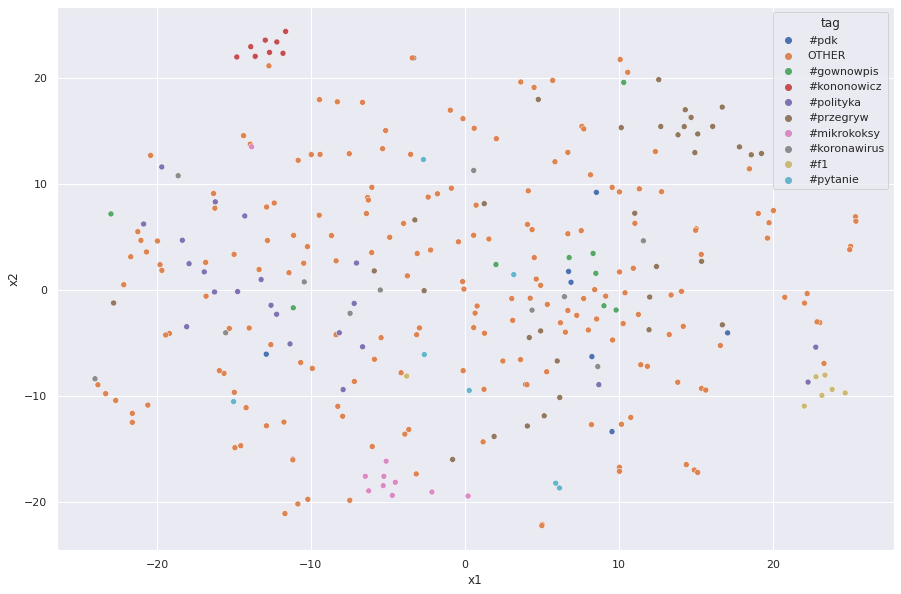

In [33]:
import matplotlib.pyplot as plt

tsne_df = pd.DataFrame({'x1': tsne_results[:,0], 'x2': tsne_results[:,1], 'tag': tags})

plt.figure(figsize=(15, 10))
sns.scatterplot(x="x1", y="x2", hue="tag",
    data=tsne_df, alpha=1, palette="deep"
)

In [25]:
import pickle

pickle.dump( user_embeddings, open( "user_embeddings_big.p", "wb" ) )